## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os, random, codecs, json, pickle
seed = 99
random.seed(seed)
np.random.seed(seed)
from collections import Counter

from ast import literal_eval
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import bitermplus
import tqdm
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from pyvis.network import Network

import tomotopy as tp
from tomotopy.utils import Corpus
import tmplot as tmp
import altair
import ipywidgets

from imp import reload
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
print(tp.isa)

## Text Cleaning

In [2]:
#read the dataframe
kremlin = pd.read_excel('data/putin_corpus.xlsx')
kremlin.rename(columns = {'p':'text'}, inplace = True)
kremlin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33189 entries, 0 to 33188
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          33189 non-null  object
 1   URL           33189 non-null  object
 2   description   30316 non-null  object
 3   introduction  30316 non-null  object
 4   id            33189 non-null  int64 
 5   speaker       33189 non-null  object
 6   text          33189 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


In [4]:
kremlin.head()

,date,URL,description,introduction,id,speaker,text
0,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,1,Д.Медведев,Уважаемые граждане России! Дорогие друзья!
1,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,2,Д.Медведев,Вступление избранного Президента в должность –...
2,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,3,Д.Медведев,Последовательность государственного курса – эт...
3,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,4,Д.Медведев,Именно эти задачи были приоритетными для меня ...
4,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,5,Д.Медведев,Нам многое удалось – даже в непростой период г...


In [3]:
kremlin['date']

0        2012-05-07
1        2012-05-07
2        2012-05-07
3        2012-05-07
4        2012-05-07
            ...    
33184    2022-08-16
33185    2022-08-16
33186    2022-08-16
33187    2022-08-16
33188    2022-08-16
Name: date, Length: 33189, dtype: object

In [ ]:
# words like НАТО and Евросоюз are in the dataset
kremlin[kremlin['text'].str.contains('Евросоюз')]

In [ ]:
#delete entries with less than 15 words (mostly greetings)
kremlin['word_count'] = kremlin['text'].str.split().str.len()
kremlin['word_count'].sort_values(ascending=False)


In [ ]:
short_text = kremlin[kremlin['word_count'] < 15]

In [ ]:
short_text[short_text['text'].str.contains('Евросоюз')]

In [ ]:
df = kremlin[kremlin['word_count'] > 15].reset_index(drop=True)

In [ ]:
df[df['text'].str.contains('Евросоюз')].sort_values(by= 'word_count', ascending=False).head()

In [ ]:
#Identify Noise with Regular Expression
import re 
RE_SUSPICIOUS = re.compile(r'[Äô&#<>{}\[\]\\]')

def impurity(text, min_len=10): 
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len: 
        return 0 
    else: 
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [ ]:
# add new column to data frame
df['impurity'] = df['text'].apply(impurity, min_len=10)
df['impurity'].sort_values().value_counts()

In [ ]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

In [ ]:
#create a function to clean the text
def clean(text):
     # everything non-alpahnumeric with a space
     text = re.sub(r'\W+',' ', text)
     # Two or more dots with one
     text = re.sub(r'\.{2,}', ' ', text)
     # this code made several words to disappear
     #convert text to lowercase             
     text = text.lower()
     #match all digits
     text = re.sub(r'\d+',' ', text)
     # sequences of white spaces
     text = re.sub(r'\s+', ' ', text) 
     return text.strip()

In [ ]:
#apply the function
df['text'] = df['text'].map(clean)

In [ ]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

In [ ]:
df.drop(columns=['impurity'], inplace=True)

In [ ]:
df[df['text'].str.contains('евросоюз')]

## Text Preprocessing

In [ ]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ru.stop_words import STOP_WORDS

In [ ]:
nlp_spacy = spacy.load('ru_core_news_sm', exclude=["ner"])
nlp_spacy.disable_pipe("parser")
nlp_spacy.enable_pipe("senter")

In [ ]:
#let’s build phrase models that we can clean and use to create the corpus for our analysis
bigram = gensim.models.Phrases(df['text'], min_count = 5,
                               threshold = 100)

In [ ]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
#Customise Stopwords
from spacy.lang.ru import stop_words
nlp_spacy.Defaults.stop_words |= {'делать', 'день', 'дорогой','думать', 'добрый', 'два', 'коллега','знать','год','господин','миллиард', 'новый',
                                    'раз', 'ни', 'понимать','президент','процент','путин', 'сегодня','слово','спасибо', 'уважаемый', 'уважаемыe','владимир','владимирович', 'видеть','хотеть'}
stop_words = stop_words.STOP_WORDS
#custom_stop_words = [word for word in nlp_spacy.Defaults.stop_words if word not in ["eвросоюз", "нато"]]

In [ ]:
lemma = []
#Turn words into lemmas
for doc in nlp_spacy.pipe(df['text'].astype('unicode').values, batch_size=50):
    lemma.append([n.lemma_.lower() for n in doc
                if n.lemma_.lower() not in stop_words])

df['lemma'] = lemma

In [ ]:
df[df['text'].str.contains('евросоюз')]

In [ ]:
df.to_pickle('data/df_lemma.pkl')

### Read saved lemma corpus

In [10]:
#read and transform the preprocessed data in a list
read_lemma = pd.read_pickle('data/df_lemma.pkl')
data_lemma = read_lemma['lemma'].tolist()

In [3]:
read_lemma[read_lemma['text'].str.contains('нато')]

,date,URL,description,introduction,id,speaker,text,word_count,lemma
12,2012-05-07,http://kremlin.ru/events/president/news/15224,В Большом Кремлёвском дворце состоялась торжес...,В Большом Кремлёвском дворце состоялась торжес...,19,В.Путин,мы вместе прошли большой и сложный путь повери...,100,"[вместе, пройти, большой, сложный, путь, повер..."
120,2012-05-26,http://kremlin.ru/events/president/news/15445,Участники съезда единогласно избрали на пост п...,Участники съезда единогласно избрали на пост п...,9,В.Путин,поэтому считаю правильным чтобы во главе парти...,50,"[считать, правильный, глава, партия, стоять, д..."
132,2012-05-26,http://kremlin.ru/events/president/news/15445,Участники съезда единогласно избрали на пост п...,Участники съезда единогласно избрали на пост п...,21,В.Путин,предлагаю съезду партии кандидатуру дмитрия ан...,22,"[предлагать, съезд, партия, кандидатура, дмитр..."
133,2012-05-26,http://kremlin.ru/events/president/news/15445,Участники съезда единогласно избрали на пост п...,Участники съезда единогласно избрали на пост п...,22,В.Путин,прежде всего хочу поздравить дмитрия анатольев...,19,"[поздравить, дмитрий, анатолиевич, избрание, п..."
240,2012-06-15,http://kremlin.ru/events/president/transcripts...,NaN,NaN,6,В.Путин,это всё говорит о том что эта территория польз...,49,"[говорить, территория, пользоваться, особый, в..."
...,...,...,...,...,...,...,...,...,...
25681,2022-06-18,http://kremlin.ru/events/president/news/68673,Накануне Дня медицинского работника Владимир П...,Накануне Дня медицинского работника Владимир П...,76,А.Попов,сегодня мы открываем новую инфекционную больни...,59,"[открывать, инфекционный, больница, одновремен..."
25768,2022-06-18,http://kremlin.ru/events/president/news/68673,Накануне Дня медицинского работника Владимир П...,Накануне Дня медицинского работника Владимир П...,285,М.Мурашко,полностью отечественное оборудование непосредс...,52,"[полностью, отечественный, оборудование, непос..."
25874,2022-06-30,http://kremlin.ru/events/president/news/68790,Глава государства возложил цветы к подножию мо...,Глава государства возложил цветы к подножию мо...,27,С.Нарышкин,мы в полной мере осознаём возрастающую значимо...,58,"[полный, мера, осознаём, возрастать, значимост..."
25923,2022-08-16,http://kremlin.ru/events/president/news/69166,NaN,NaN,7,В.Путин,вот почему коллективный запад так называемый к...,76,"[коллективный, запад, называть, коллективный, ..."


In [4]:
print(read_lemma.iloc[25928]["text"])

мы также видим что коллективный запад стремится распространить на азиатско тихоокеанский регион свою блоковую систему по аналогии с нато в европе с этой целью формируются агрессивные военно политические союзы такие как aukus и другие


In [6]:
len(data_lemma)

25936

In [26]:
docs = data_lemma
# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more).
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [27]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
# Filter out words that occur less than in 5 documents, or more than 50% of the documents.
max_freq = 0.5
min_wordcount = 5

In [28]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(docs)))

Number of unique tokens: 8731
Number of docs: 25936 (25936)


In [29]:
from collections import Counter
c = Counter()
for d in docs:
    c.update(d)

# 10 least common words in the corpus, by frequency
c.most_common()[-10:]

[('тоталитаризм', 1),
 ('подчиниться', 1),
 ('разваливать', 1),
 ('сколачивать', 1),
 ('хаотизации', 1),
 ('деиндустриализация', 1),
 ('aukus', 1),
 ('цепляться', 1),
 ('бенефициары', 1),
 ('глобалистской', 1)]

In [30]:
c = Counter()
for d in docs:
    c.update(d)

# 10 most common words in the corpus, by frequency
c.most_common(min_wordcount)

[('россия', 6442),
 ('страна', 6274),
 ('человек', 4116),
 ('развитие', 3443),
 ('работа', 3368)]

In [10]:
from itertools import chain
c = Counter(chain.from_iterable(docs))
#for d in docs:
    #c.update(d)
word = 'нато'
print("The word '{}' appears {} times in the list of lists.".format(word, c[word]))

The word 'нато' appears 126 times in the list of lists.


In [11]:
dictionary.token2id['нато']

4509

## Correlated Topic Model 15 topics

In [32]:
import tomotopy as tp

# CTM model with 15 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count, remove the 5 most common words
params = {'num_topics': 15, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 5, 'random_state': seed}

In [24]:
ctm = tp.CTModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],
        seed=params['random_state'],rm_top=params['rm_top'])

In [25]:
# Since we have more than ten thousand of documents, 
# setting the `num_beta_sample` smaller value will not cause an inaccurate result.
ctm.num_beta_sample = 5

In [26]:
for doc in docs:
    ctm.add_doc(doc)

for i in range(0, 1001, 100):
    ctm.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, ctm.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_2376/3222773177.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  ctm.train(10)


Iteration: 0	Log-likelihood: -8.537414039599726
Iteration: 100	Log-likelihood: -7.691137502400132
Iteration: 200	Log-likelihood: -7.376247053716817
Iteration: 300	Log-likelihood: -7.279474955197985
Iteration: 400	Log-likelihood: -7.240710953830579
Iteration: 500	Log-likelihood: -7.218669976717852
Iteration: 600	Log-likelihood: -7.225569427978337
Iteration: 700	Log-likelihood: -7.230497656081447
Iteration: 800	Log-likelihood: -7.219651593461853
Iteration: 900	Log-likelihood: -7.211487754846329
Iteration: 1000	Log-likelihood: -7.205283663462073


In [18]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(ctm.docs), len(ctm.used_vocabs), ctm.num_words
))

Num docs:25936, Num Vocabs:999, Total Words:398102


In [19]:
print('Removed Top words: ', *ctm.removed_top_words)

Removed Top words:  россия страна человек развитие работа


In [27]:
for k in range(ctm.k):
        print('Topic #{}'.format(k))
        for word, prob in ctm.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		экономика	0.05787384882569313
		рынок	0.05543635040521622
		рост	0.03677208349108696
		газ	0.03447387367486954
		компания	0.03294173255562782
		мировой	0.032175660133361816
		речь	0.02674352377653122
		идти	0.023957813158631325
		производство	0.023470314219594002
		энергетика	0.022356029599905014
Topic #1
		первый	0.08366795629262924
		территория	0.0450720340013504
		мера	0.04098239913582802
		полный	0.04064159467816353
		характер	0.036637160927057266
		очередь	0.029139498248696327
		бюджет	0.027520684525370598
		относиться	0.022238239645957947
		значение	0.021130628883838654
		хозяйство	0.020534224808216095
Topic #2
		решение	0.04331524297595024
		экономика	0.037095777690410614
		сфера	0.03587409481406212
		технология	0.03531878814101219
		цифровой	0.032542239874601364
		среда	0.031875867396593094
		здравоохранение	0.03143162280321121
		социальный	0.029321445152163506
		рубль	0.0272112675011158
		повышение	0.023657288402318954
Topic #3
		участие	0.031893711537122726
		прини

In [28]:
# Let's visualize the result
g = Network(width=800, height=800, font_color="#333")
correl = ctm.get_correlations().reshape([-1])
correl.sort()
top_tenth = ctm.k * (ctm.k - 1) // 10
top_tenth = correl[-ctm.k - top_tenth]

for k in range(ctm.k):
    label = "#{}".format(k)
    title= ' '.join(word for word, _ in ctm.get_topic_words(k, top_n=6))
    print('Topic', label, title)
    g.add_node(k, label=label, title=title, shape='ellipse')
    for l, correlation in zip(range(k - 1), ctm.get_correlations(k)):
        if correlation < top_tenth: continue
        g.add_edge(k, l, value=float(correlation), title='{:.02}'.format(correlation))

g.barnes_hut(gravity=-1000, spring_length=20)
g.show_buttons()
g.show("topic_network.html")

Topic #0 экономика рынок рост газ компания мировой
Topic #1 первый территория мера полный характер очередь
Topic #2 решение экономика сфера технология цифровой среда
Topic #3 участие принимать принять спорт штат большой
Topic #4 восток дальний дальний_восток регион доллар точка
Topic #5 великий война русский народ история культура
Topic #6 российский федерация центр российский_федерация технология медицинский
Topic #7 молодой первый заниматься сказать говорить знание
Topic #8 орган союз закон безопасность право власть
Topic #9 успех высокий праздник награда поколение вклад
Topic #10 проект внимание реализация компания программа бизнес
Topic #11 экономический международный сотрудничество вопрос отношение партнёр
Topic #12 мир дело общий жизнь государство сила
Topic #13 число задача уровень система необходимый условие
Topic #14 говорить важный сказать работать сделать хороший


In [32]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(ctm, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(ctm.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -3.3218638274429586 
Per Topic: [-3.010987803874249, -4.590648481360642, -4.176651226311114, -3.0913748728826995, -3.1635150074530487, -3.3169076071159482, -2.902765027233643, -3.451080690080684, -3.5348266456284105, -4.553656104674068, -2.7807152719518857, -2.9961596493457394, -2.96037472341257, -2.711391028946181, -2.5869032713734907]

==== Coherence : c_uci ====
Average: -0.31536439796076243 
Per Topic: [0.6396654288947707, -1.783060681198974, -0.8890272180670318, -0.2334448192375141, -1.0204479120932617, -0.9616379867334968, 0.09979149490053207, 0.6806266718278278, -1.013700372652914, -1.0153208827088902, 0.6167445135741266, -0.03575309411234966, 0.2021306149871979, -0.02307864962005996, 0.006046922828601739]

==== Coherence : c_npmi ====
Average: 0.03263858646731498 
Per Topic: [0.1248669505045296, -0.012481495584977869, 0.017783469454871685, 0.05923375353451323, 0.0489353486075446, -0.007019179965756599, 0.05654984632551459, 0.089990559135845

In [ ]:
ctm.save('models/ctm_15_topics_reduced_corpus.bin')

In [31]:
ctm = tp.CTModel.load('models/ctm_15_topics_reduced_corpus.bin')
for k in range(ctm.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(ctm.get_topic_words(k, top_n=10))

ctm.load('models/ctm_15_topics_reduced_corpus.bin')

Top 10 words of topic #0
[('война', 0.042973872274160385), ('великий', 0.0391751267015934), ('народ', 0.038462862372398376), ('сила', 0.031280867755413055), ('победа', 0.030806023627519608), ('желать', 0.020774967968463898), ('вооружённый', 0.02065625786781311), ('отечество', 0.01964721642434597), ('родина', 0.01881624199450016), ('память', 0.018756886944174767)]
Top 10 words of topic #1
[('семья', 0.0767105221748352), ('высокий', 0.05734938755631447), ('рабочий', 0.05649161711335182), ('ребёнок', 0.05575638264417648), ('следующий', 0.054530996829271317), ('труд', 0.0504872128367424), ('место', 0.04717866703867912), ('награда', 0.04693358764052391), ('оценка', 0.027940072119235992), ('рабочий_место', 0.02512167952954769)]
Top 10 words of topic #2
[('принять', 0.0969354435801506), ('идти', 0.08539339154958725), ('союз', 0.057148195803165436), ('выбор', 0.04701370745897293), ('соглашение', 0.04053889587521553), ('решение', 0.03838062286376953), ('речь', 0.03594084084033966), ('советский'

In [ ]:
#theta(topics vs documents probability) matrices
#tmp.get_theta(ctm).head()

In [ ]:
#get documents with maximum probabilities for each topic
#tmp.get_top_docs(docs, model=ctm)

In [ ]:
# topic correlations

topics_correlations = np.zeros((ctm.k,ctm.k))

for k in range(ctm.k):
    for m,c in enumerate(ctm.get_correlations(k)):
        topics_correlations[k][m] = c

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)])
plt.xticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins
#plt.savefig("figures/corr_topic_model_correlations_15_ctm.pdf")

#no significant correlation among topics. suspicious

## LDA 10 topics

In [12]:
import tomotopy as tp

# LDA model with 10 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count, remove the 5 most common words
params = {'num_topics': 10, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 5, 'random_state': seed, 'dic': Dictionary}

In [27]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [14]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_5792/4240426511.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda.train(10)


Iteration: 0	Log-likelihood: -7.699524474071943
Iteration: 10	Log-likelihood: -7.320708220462861
Iteration: 20	Log-likelihood: -7.147249022549305
Iteration: 30	Log-likelihood: -7.084948027070882
Iteration: 40	Log-likelihood: -7.05573382273293
Iteration: 50	Log-likelihood: -7.037393859051244
Iteration: 60	Log-likelihood: -7.028930919733438
Iteration: 70	Log-likelihood: -7.022507864348734
Iteration: 80	Log-likelihood: -7.013745230305558
Iteration: 90	Log-likelihood: -7.0057422524979565
Iteration: 100	Log-likelihood: -6.997790733584532
Iteration: 110	Log-likelihood: -6.993979351055193
Iteration: 120	Log-likelihood: -6.992813763574912
Iteration: 130	Log-likelihood: -6.989633365047926
Iteration: 140	Log-likelihood: -6.984811440966991
Iteration: 150	Log-likelihood: -6.984489094014092
Iteration: 160	Log-likelihood: -6.985069161707389
Iteration: 170	Log-likelihood: -6.983929499429367
Iteration: 180	Log-likelihood: -6.978884228898201
Iteration: 190	Log-likelihood: -6.982609579763721
Iteration: 

In [42]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		технология	0.02200279012322426
		центр	0.018115753307938576
		современный	0.014300697483122349
		научный	0.012117238715291023
		работать	0.012045256793498993
		наука	0.011805315501987934
		образование	0.011757328175008297
		сфера	0.011661351658403873
		область	0.01096552424132824
		медицинский	0.009717833250761032
Topic #1
		восток	0.05383401736617088
		дальний	0.04303818196058273
		регион	0.04077689349651337
		дальний_восток	0.039901554584503174
		северный	0.0321694016456604
		министр	0.021300621330738068
		корея	0.02057117223739624
		проект	0.020425282418727875
		российский	0.018820496276021004
		премьер	0.01794515736401081
Topic #2
		сила	0.03461212292313576
		военный	0.03366386145353317
		задача	0.02589997462928295
		боевой	0.02151426672935486
		вооружённый	0.020447472110390663
		служба	0.01997334323823452
		флот	0.0183731522411108
		безопасность	0.017247091978788376
		вооружённый_сила	0.017247091978788376
		армия	0.016772961243987083
Topic #3
		говорить	0.03561039641499

In [16]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

Num docs:25936, Num Vocabs:999, Total Words:398102


In [17]:
print('Removed Top words: ', *lda.removed_top_words)

Removed Top words:  россия страна человек развитие работа


In [ ]:
#lda.summary()

In [18]:
lda.save('models/lda_tomotopy_10t.bin')

In [2]:
lda = tp.LDAModel.load('models/lda_tomotopy_10t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_10t.bin')

Top 10 words of topic #0
[('технология', 0.02200279012322426), ('центр', 0.018115753307938576), ('современный', 0.014300697483122349), ('научный', 0.012117238715291023), ('работать', 0.012045256793498993), ('наука', 0.011805315501987934), ('образование', 0.011757328175008297), ('сфера', 0.011661351658403873), ('область', 0.01096552424132824), ('медицинский', 0.009717833250761032)]
Top 10 words of topic #1
[('восток', 0.05383401736617088), ('дальний', 0.04303818196058273), ('регион', 0.04077689349651337), ('дальний_восток', 0.039901554584503174), ('северный', 0.0321694016456604), ('министр', 0.021300621330738068), ('корея', 0.02057117223739624), ('проект', 0.020425282418727875), ('российский', 0.018820496276021004), ('премьер', 0.01794515736401081)]
Top 10 words of topic #2
[('сила', 0.03461212292313576), ('военный', 0.03366386145353317), ('задача', 0.02589997462928295), ('боевой', 0.02151426672935486), ('вооружённый', 0.020447472110390663), ('служба', 0.01997334323823452), ('флот', 0.0

In [21]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [22]:
pyLDAvis.enable_notebook()

In [23]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [24]:
prepared_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.019265  0.044876       0        1  10.298589
1     -0.216311 -0.265571       1        1   3.442372
2      0.154038  0.169502       2        1   4.229972
3     -0.016711  0.032908       3        1  15.805373
4     -0.033710  0.149561       4        1  14.066221
5     -0.035582  0.145297       5        1  10.823456
6     -0.138067 -0.045499       6        1   9.875501
7     -0.162888  0.066079       7        1  11.379317
8      0.211594 -0.196235       8        1   8.506977
9      0.256901 -0.100917       9        1  11.572223, topic_info=               Term         Freq        Total Category  logprob  loglift
14   сотрудничество  2780.000000  2780.000000  Default  30.0000  30.0000
9            регион  3208.000000  3208.000000  Default  29.0000  29.0000
95           восток  1348.000000  1348.000000  Default  28.0000  28.0000
31             сила  2246.000000  2246.000000  Default  27.0000  27.0000
1          говорить  5184.000000  5184.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
36            общий   537.006219  2127.696172   Topic9  -4.9572   0.7798
0        российский   585.659528  5406.104361   Topic9  -4.8705  -0.0660
35          мировой   511.778597  2117.338702   Topic9  -5.0053   0.7365
127           семья   466.729265  1161.748886   Topic9  -5.0974   1.2446
3            важный   522.590456  4799.585067   Topic9  -4.9844  -0.0609

[531 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
317       0  0.082047  абсолютно
317       3  0.820467  абсолютно
317       5  0.097825  абсолютно
411       1  0.569336       азия
411       5  0.184543       азия
...     ...       ...        ...
288       8  0.046786     япония
733       1  0.621560   японский
733       3  0.129360   японский
733       6  0.186152   японский
733       7  0.063103   японский

[1427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -2.63346697752815 
Per Topic: [-2.7491387108343517, -2.5849568723413365, -2.464662819103826, -2.578214070312209, -2.630182852546383, -2.6619203456011036, -2.3046299932305585, -2.7628413164005923, -2.932979811171651, -2.6651429837394858]

==== Coherence : c_uci ====
Average: 0.543712272782622 
Per Topic: [0.6130031067675314, 0.4619738954135745, 1.4416420906857648, -0.032157406698623464, 0.3524557948660905, 0.39450450808226617, 0.4246566309832346, 0.5236521532809738, 0.36448072403969095, 0.8929112304057166]

==== Coherence : c_npmi ====
Average: 0.07932308901790985 
Per Topic: [0.0860016679409476, 0.10430741299544181, 0.1773291079614933, -0.0021187663911886602, 0.05182916119281506, 0.05483892843279806, 0.06462442401581366, 0.07389198675264821, 0.05408590745503484, 0.12844105982329468]

==== Coherence : c_v ====
Average: 0.6102857897803188 
Per Topic: [0.6015780627727508, 0.6455084323883057, 0.737009871006012, 0.46137031614780427, 0.5397900760173797, 

In [71]:
def corpus_and_labeling_example(model):
    # extract candidates for auto topic labeling
    extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
    cands = extractor.extract(lda)

    labeler = tp.label.FoRelevance(lda, cands, min_df=5, smoothing=1e-2, mu=0.25)
    for k in range(lda.k):
        print("== Topic #{} ==".format(k))
        print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
        for word, prob in lda.get_topic_words(k, top_n=10):
            print(word, prob, sep='\t')
        print()

In [72]:
print('Running LDA and Labeling')
corpus_and_labeling_example(lda)

Running LDA and Labeling
== Topic #0 ==
Labels: передовой, технология, внедрение, образовательный, технологический
технология	0.02200279012322426
центр	0.018115753307938576
современный	0.014300697483122349
научный	0.012117238715291023
работать	0.012045256793498993
наука	0.011805315501987934
образование	0.011757328175008297
сфера	0.011661351658403873
область	0.01096552424132824
медицинский	0.009717833250761032

== Topic #1 ==
Labels: морской путь, северный морской путь, дальний восток, дальний_восток, северный морской
восток	0.05383401736617088
дальний	0.04303818196058273
регион	0.04077689349651337
дальний_восток	0.039901554584503174
северный	0.0321694016456604
министр	0.021300621330738068
корея	0.02057117223739624
проект	0.020425282418727875
российский	0.018820496276021004
премьер	0.01794515736401081

== Topic #2 ==
Labels: армия_флот, армия флот, личный состав, вооружённый_сила, вооружённый сила
сила	0.03461212292313576
военный	0.03366386145353317
задача	0.02589997462928295
боевой	0.0

In [74]:
# theta(topics vs documents probability) matrix
tmp.get_theta(lda).head(10)

docs,0,1,2,3,4,5,6,7,8,9,...,25926,25927,25928,25929,25930,25931,25932,25933,25934,25935
topics,,,,,,,,,,,,,,,,,,,,,
0,0.006495,0.004345,0.207953,0.006157,0.009694,0.004047,0.010560,0.007779,0.037081,0.007298,...,0.004047,0.004884,0.099961,0.004047,0.006873,0.004511,0.003559,0.004047,0.016439,0.008959
1,0.002290,0.001532,0.004089,0.002171,0.003418,0.001427,0.003723,0.002743,0.013074,0.002573,...,0.275535,0.043069,0.003723,0.001427,0.002423,0.001590,0.001255,0.001427,0.005796,0.003159
2,0.002735,0.001830,0.004883,0.002592,0.660596,0.001704,0.004447,0.003275,0.015613,0.003073,...,0.001704,0.002056,0.004447,0.104495,0.002894,0.001899,0.543903,0.001704,0.006922,0.003772
3,0.066734,0.007857,0.413683,0.480236,0.099593,0.007319,0.019096,0.014066,0.067052,0.013197,...,0.178636,0.256913,0.019096,0.007319,0.186994,0.008157,0.006436,0.007319,0.447229,0.016199
4,0.173635,0.410425,0.113656,0.112462,0.012937,0.245246,0.282297,0.339642,0.049489,0.812925,...,0.005402,0.047865,0.014094,0.073929,0.009173,0.006020,0.004751,0.210983,0.021940,0.011956
5,0.391758,0.004574,0.110385,0.058603,0.010204,0.004260,0.189918,0.008188,0.039031,0.007682,...,0.415422,0.625346,0.458120,0.758057,0.472742,0.806717,0.184548,0.586740,0.017304,0.161111
6,0.006332,0.335294,0.109483,0.006002,0.009450,0.209527,0.010295,0.007583,0.036148,0.007114,...,0.106736,0.004761,0.367898,0.003945,0.297642,0.157153,0.244539,0.175263,0.016025,0.691298
7,0.116849,0.004597,0.012269,0.319249,0.010256,0.072809,0.011172,0.008229,0.039230,0.007721,...,0.004282,0.005167,0.011172,0.004282,0.007272,0.004772,0.003766,0.004282,0.017392,0.085318
8,0.006209,0.004154,0.011086,0.005886,0.009266,0.003869,0.457099,0.336696,0.663278,0.130543,...,0.003869,0.004669,0.010095,0.003869,0.006570,0.004312,0.003403,0.003869,0.433218,0.008564


In [75]:
#get documents with maximum probabilities 𝑃(𝑡|𝑑) for each topic
tmp.get_top_docs(docs, model=lda)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,"[молодой, смело, браться, сложный, задача, дос...","[уникальный, возможность, иметься, реализация,...","[соответствие, утвердить, план, повышаться, ка...","[история, пример, подход, решение, надеяться, ...","[завершение, остановиться, важный, тема, прошл...","[случай, сказать, чувствительный, серьёзный, в...","[полагать, полезный, дополнять, взаимодействие...","[смотреть, вид, производство, достигнуть, уров...","[первый, очередь, хотеться, поздравить, спортс...","[город, герое, севастополь, крым, огромный, ст..."
1,"[прогноз, эксперт, результат, внедрение, машин...","[уважаемые, председатель, китайский, народный,...","[современный, облик, вооружённый, сила, послед...","[история, решить, провести, сегодняшний, встре...","[статус, получить, предполагать, первый, чётки...","[нынешний, сложный, условие, страна, важный, п...","[вестись, работа, организация, интеграционный,...","[пандемия, валовой, внутренний, продукт, монго...","[выразить, огромный, благодарность, студент, а...","[возрождать, исторический, правда, первый, мир..."
2,"[эксплуатация, обслуживание, аэс, будущее, раб...","[превосходительство, российский, федерация, пр...","[продолжать, традиция, фронтовик, дед, отец, л...","[повод, событие, украина, говорить, уйти, врем...","[вместе, зона, личный, ответственность, прокур...","[очевидный, подчеркнуть, суверенный, растворим...","[китайский, сторона, уверена, появление, полно...","[показателен, факт, россия, поступить, доллар,...","[заключение, выразить, искренний, признательно...","[исполняться, начало, первый, мировой, война, ..."
3,"[предстоять, кардинальный, образ, обновить, ин...","[усилие, нефтяник, газовик, укреплялась, эконо...","[росгвардия, достойно, продолжать, развивать, ...","[уверенный, процитировать, марк, твен, говорит...","[момент, достаточно, существенный, принять, до...","[повторить, фон, фундаментальный, трансформаци...","[россия, придаёт, большой, значение, выстраива...","[считать, поставить, задача, национальный, уро...","[глава, государство, прекрасный, спортсмен, за...","[война, длиться, малый, четыре, целый, эпоха, ..."
4,"[отличный, школа, область, математика, теорети...","[россия, председатель, китайский, народный, ре...","[дело, доказывать, готовый, сложный, условие, ...","[помнить, шум, повод, rt, спутник, рекламный, ...","[осуществляться, активный, целенаправленный, м...","[россия, серьёзный, вызов, учитывать, формиров...","[узбекистан, рамка, председательство, шос, нам...","[потребоваться, строительство, завод, тысяча, ...","[собраться, чемпион, зимний, летний, игра, раз...","[июнь, особый, дата, россия, народ, нацист, ве..."


### Examine topics distribution

In [103]:
lda.docs[0].get_topic_dist()

array([0.00649545, 0.00229016, 0.002735  , 0.06673408, 0.17363493,
       0.39175776, 0.00633196, 0.11684921, 0.00620914, 0.22696228],
      dtype=float32)

In [106]:
#for each document, get the topic distribution
topic_distributions = [list(doc.get_topic_dist()) for doc in lda.docs]

In [110]:
topics = np.zeros((len(docs),params['num_topics']))

In [115]:
topics[2,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [117]:
df_topic_distributions  = pd.DataFrame(topic_distributions )
df_topic_distributions 

,0,1,2,3,4,5,6,7,8,9
0,0.006495,0.002290,0.002735,0.066734,0.173635,0.391758,0.006332,0.116849,0.006209,0.226962
1,0.004345,0.001532,0.001830,0.007857,0.410425,0.004574,0.335294,0.004597,0.004154,0.225393
2,0.207953,0.004089,0.004883,0.413683,0.113656,0.110385,0.109483,0.012269,0.011086,0.012512
3,0.006157,0.002171,0.002592,0.480236,0.112462,0.058603,0.006002,0.319249,0.005886,0.006642
4,0.009694,0.003418,0.660596,0.099593,0.012937,0.010204,0.009450,0.010256,0.009266,0.174587
...,...,...,...,...,...,...,...,...,...,...
25931,0.004511,0.001590,0.001899,0.008157,0.006020,0.806717,0.157153,0.004772,0.004312,0.004867
25932,0.003559,0.001255,0.543903,0.006436,0.004751,0.184548,0.244539,0.003766,0.003403,0.003840
25933,0.004047,0.001427,0.001704,0.007319,0.210983,0.586740,0.175263,0.004282,0.003869,0.004366
25934,0.016439,0.005796,0.006922,0.447229,0.021940,0.017304,0.016025,0.017392,0.433218,0.017735


In [118]:
time = read_lemma.date.tolist()

In [119]:
df_topic_distributions["year"] = time

In [121]:
df_topic_distributions

,0,1,2,3,4,5,6,7,8,9,year
0,0.006495,0.002290,0.002735,0.066734,0.173635,0.391758,0.006332,0.116849,0.006209,0.226962,2012-05-07
1,0.004345,0.001532,0.001830,0.007857,0.410425,0.004574,0.335294,0.004597,0.004154,0.225393,2012-05-07
2,0.207953,0.004089,0.004883,0.413683,0.113656,0.110385,0.109483,0.012269,0.011086,0.012512,2012-05-07
3,0.006157,0.002171,0.002592,0.480236,0.112462,0.058603,0.006002,0.319249,0.005886,0.006642,2012-05-07
4,0.009694,0.003418,0.660596,0.099593,0.012937,0.010204,0.009450,0.010256,0.009266,0.174587,2012-05-07
...,...,...,...,...,...,...,...,...,...,...,...
25931,0.004511,0.001590,0.001899,0.008157,0.006020,0.806717,0.157153,0.004772,0.004312,0.004867,2022-08-16
25932,0.003559,0.001255,0.543903,0.006436,0.004751,0.184548,0.244539,0.003766,0.003403,0.003840,2022-08-16
25933,0.004047,0.001427,0.001704,0.007319,0.210983,0.586740,0.175263,0.004282,0.003869,0.004366,2022-08-16
25934,0.016439,0.005796,0.006922,0.447229,0.021940,0.017304,0.016025,0.017392,0.433218,0.017735,2022-08-16


In [126]:
from_which_year = '2011.01.01'
grouped = df_topic_distributions.groupby('year')
df_grouped = grouped.aggregate(np.mean)
df_grouped = df_grouped[df_grouped.index >= from_which_year]

In [127]:
df_grouped

,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
2012-05-07,0.037704,0.003032,0.056590,0.087613,0.188119,0.059043,0.053117,0.036819,0.246970,0.230993
2012-05-09,0.016936,0.012930,0.018629,0.070029,0.031871,0.046737,0.016510,0.017918,0.078970,0.689471
2012-05-22,0.277685,0.008478,0.064963,0.119632,0.216592,0.071591,0.033495,0.092688,0.068495,0.046380
2012-05-24,0.013574,0.004786,0.010771,0.250123,0.052233,0.069368,0.123088,0.031336,0.158473,0.286247
2012-05-26,0.056446,0.007485,0.018135,0.092800,0.419664,0.142148,0.093255,0.037426,0.038260,0.094382
...,...,...,...,...,...,...,...,...,...,...
2022-07-31,0.030275,0.012753,0.427880,0.052674,0.020088,0.064838,0.015686,0.041787,0.064253,0.269766
2022-08-07,0.397211,0.034109,0.016471,0.039391,0.078901,0.016737,0.045025,0.091008,0.250389,0.030759
2022-08-09,0.026693,0.017575,0.014310,0.121244,0.051751,0.010597,0.009814,0.010651,0.076125,0.661241


ValueError: invalid literal for int() with base 10: '2012-05-07'

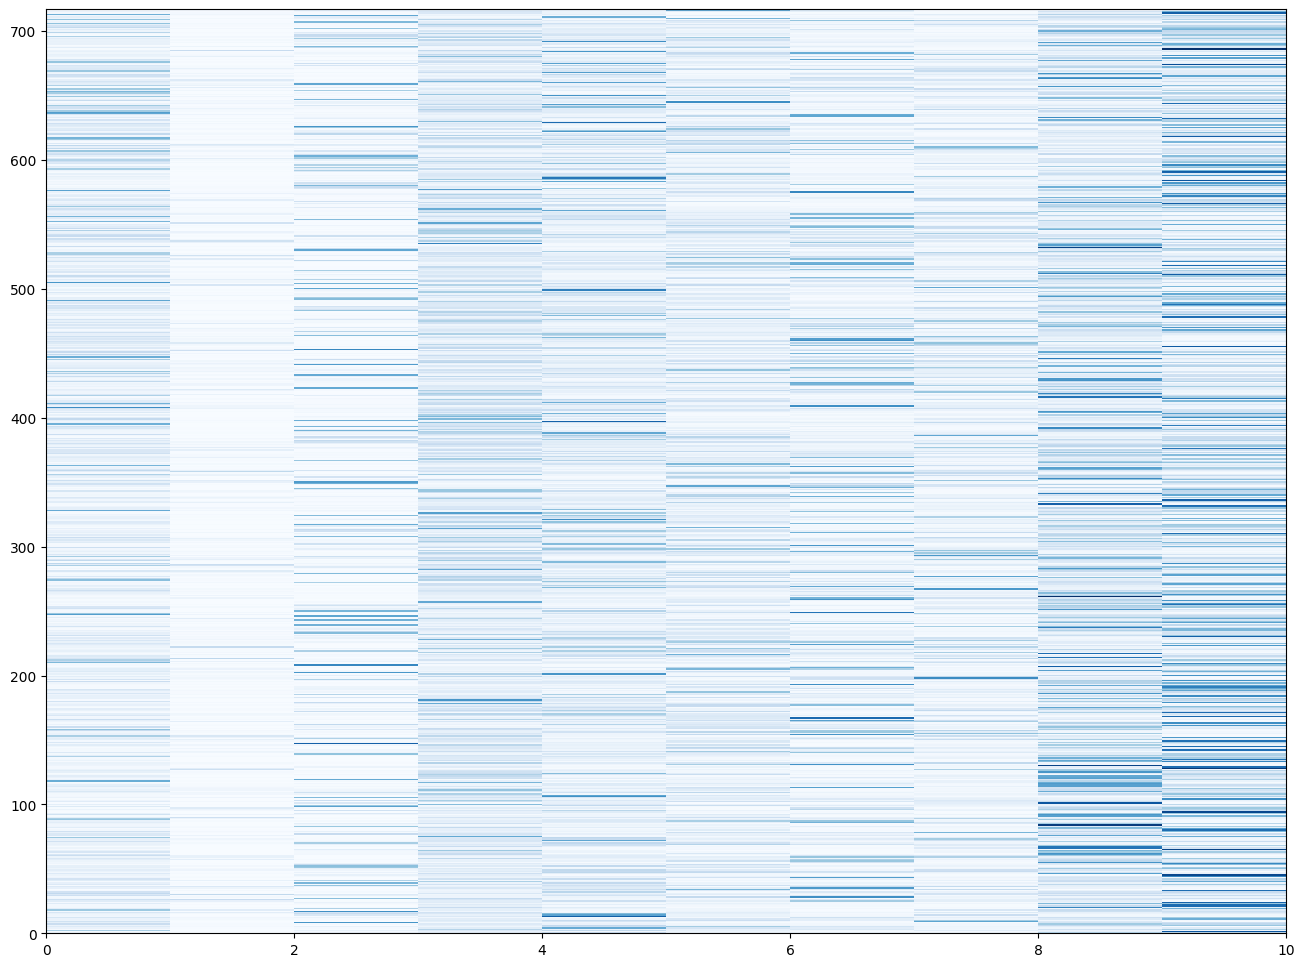

In [128]:
fig = plt.figure(figsize=(16, 12))
plt.pcolor(df_grouped.to_numpy(), norm=None, cmap='Blues')
plt.yticks(np.arange(df_grouped.to_numpy().shape[0])+0.5, [int(x) for x in df_grouped.index.values])
plt.xticks(np.arange(df_grouped.to_numpy().shape[1])+0.5, ["Topic #"+str(n) for n in range(lda.num_topics)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
#plt.savefig("figures/nb2_topic_model_all_time_15.pdf")
plt.show()

In [57]:
topic_list = []
# Iterate over the topics
for k in range(lda.k):
    # Get the topic words
    topic_words = lda.get_topic_words(k)
    for word, prob in topic_words:
        topic_list.append({'topic': "Topic #{}".format(k), 'word': word, 'prob': prob})
topic_df = pd.DataFrame(topic_list)
# Set the topic column as the index
topic_df.set_index('topic', inplace=True)

In [65]:
read_lemma["date"]

0        2012-05-07
1        2012-05-07
2        2012-05-07
3        2012-05-07
4        2012-05-07
            ...    
25931    2022-08-16
25932    2022-08-16
25933    2022-08-16
25934    2022-08-16
25935    2022-08-16
Name: date, Length: 25936, dtype: object

In [67]:
import numpy as np 
before_2014 = np.array(read_lemma["date"] < '2014-01-01') 
after_2014 = ~ before_2014

## LDA 20 topics

In [ ]:
params = {'num_topics': 20, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 30, 'random_state': seed}

In [ ]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [ ]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

In [ ]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

In [ ]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

In [ ]:
print('Removed Top words: ', *lda.removed_top_words)

In [ ]:
lda.save('models/lda_tomotopy_20t.bin')

In [ ]:
lda = tp.LDAModel.load('models/lda_tomotopy_20t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_20t.bin')

In [ ]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])

In [ ]:
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])

In [ ]:
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

In [ ]:
from collections import Counter
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)

In [ ]:
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

In [ ]:
prepared_data

In [ ]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

## LDA 25 topics

In [ ]:
params = {'num_topics': 25, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'rm_top': 30, 'random_state': seed}

In [ ]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'],rm_top=params['rm_top'])

In [ ]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

In [ ]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

In [ ]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(lda.docs), len(lda.used_vocabs), lda.num_words
))

In [ ]:
print('Removed Top words: ', *lda.removed_top_words)

In [ ]:
lda.save('models/lda_tomotopy_25t.bin')

In [ ]:
lda = tp.LDAModel.load('models/lda_tomotopy_25t.bin')
for k in range(lda.k):
    #if not mdl.is_live_topic(k): continue
    print('Top 10 words of topic #{}'.format(k))
    print(lda.get_topic_words(k, top_n=10))

lda.load('models/lda_tomotopy_25t.bin')

In [ ]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])

In [ ]:
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])

In [ ]:
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)

In [ ]:
from collections import Counter
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)

In [ ]:
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

In [ ]:
prepared_data

In [ ]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

## LDA gensim 10 topics

In [51]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 10,'passes': 10, 'random_state': seed}

model = LdaModel(corpus=corpus, num_topics=params['num_topics'], id2word=dictionary, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 2min 10s, sys: 2.05 s, total: 2min 12s
Wall time: 2min 29s


In [52]:
model.show_topics(num_words=30, num_topics=params['num_topics'])

[(0,
  '0.014*"тысяча" + 0.014*"военный" + 0.012*"участие" + 0.011*"работа" + 0.010*"принять" + 0.009*"оружие" + 0.009*"состав" + 0.008*"техника" + 0.008*"мероприятие" + 0.007*"оборона" + 0.007*"боевой" + 0.007*"современный" + 0.007*"вооружение" + 0.007*"принимать" + 0.007*"министерство" + 0.007*"флот" + 0.006*"служба" + 0.006*"конституция" + 0.006*"морской" + 0.006*"медицинский" + 0.006*"инфекция" + 0.006*"ход" + 0.005*"военно" + 0.005*"задача" + 0.005*"подготовка" + 0.005*"войско" + 0.005*"сила" + 0.005*"операция" + 0.005*"специальный" + 0.005*"дело"'),
 (1,
  '0.027*"безопасность" + 0.014*"борьба" + 0.013*"право" + 0.012*"угроза" + 0.011*"орган" + 0.011*"международный" + 0.010*"внимание" + 0.009*"число" + 0.009*"обеспечение" + 0.008*"санкция" + 0.008*"гражданин" + 0.008*"сила" + 0.007*"работа" + 0.007*"защита" + 0.007*"мера" + 0.007*"государство" + 0.007*"терроризм" + 0.006*"интерес" + 0.006*"против" + 0.006*"преступление" + 0.006*"дело" + 0.006*"нарушение" + 0.006*"страна" + 0.006*

In [57]:
from imp import reload
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

In [59]:
# plot topics (NOTE: the IDs here do not match those from the model)
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(data)

/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Rhetoric Ratio Score